This file is to clearn the TUH EEG seizure data

1. Create a csv file to contains all edf and the labels

2. A class to load data


In [67]:
import sys
sys.path.append("../mypkg")
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT

In [68]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from easydict import EasyDict as edict
import torch
import mne

%matplotlib inline
plt.style.use(FIG_ROOT/"base.mplstyle")

In [69]:
import importlib
import data_utils.eeg_load
importlib.reload(data_utils.eeg_load)

<module 'data_utils.eeg_load' from '/data/rajlab1/user_data/jin/MyResearch/gTVDN-NN/notebooks/../mypkg/data_utils/eeg_load.py'>

In [70]:
from data_utils.eeg_load import txt2labinfo, montage_txt_parse, EEG_data, len2num, seiz_lab_from_row_fn, digitize_data, rec_data
from utils.misc import load_txt, save_pkl, load_pkl

In [71]:
root = list(DATA_ROOT.glob("EEG_seizure"))[0]
root

PosixPath('/data/rajlab1/user_data/jin/MyResearch/gTVDN-NN/notebooks/../mypkg/../data/EEG_seizure')

# Pre-analysis

In [23]:
# all session paths
# count number of folder in each session
nums = []
for p in list(root.rglob("s0*")):
    num = len(list(p.glob("*")))
    nums.append(num)
    if num > 1:
        print(p)
    
nums = np.array(nums)
print((nums==2).sum())
print(np.max(nums))

/data/rajlab1/user_data/jin/MyResearch/gTVDN-NN/notebooks/../mypkg/../data/EEG_seizure/edf/eval/aaaaaqvx/s003_2015_08_24
/data/rajlab1/user_data/jin/MyResearch/gTVDN-NN/notebooks/../mypkg/../data/EEG_seizure/edf/eval/aaaaaqvx/s010_2015_08_27
2
2


# Output csv file

Csv file lists all files

In [10]:
names =["dataset", "sub", "session", "montage", "file_stem", "relative_path", "is_seizure", "total_dur"]
working_set = "train" # train, eval, dev 
working_path = root/("edf/"+working_set)

PosixPath('/data/rajlab1/user_data/jin/MyResearch/gTVDN-NN/notebooks/../mypkg/../data/EEG_seizure/edf/train')

In [11]:
def path2info(p):
    p_dir = "/".join(str(p).split("/")[-5:]).split('.')[0]
    txt = load_txt(p.with_suffix(".csv_bi"))
    infos = txt2labinfo(txt)
    return str(p.parent).split("/")[-4:] + [p.stem] + [p_dir] + [infos["is_seizure"]] + [infos["total_dur"]]

In [ ]:
all_infos = []
for p in tqdm(working_path.rglob("*.edf")):
    all_infos.append(path2info(p))

In [21]:
df = pd.DataFrame(all_infos, columns=names)
df.to_csv(root/f"all_data_{working_set}.csv")

# Process data and save it

In [183]:
dataset = EEG_data("train", "ALL", 
                   preprocess_dict=dict(is_detrend=True, 
                                      is_drop=True,
                                      target_fs=90, 
                                      filter_limit=[1, 45], 
                                      is_diff=False)
                  );

In [ ]:
from tqdm import trange
for ix in trange(len(dataset.all_data)):
    dataset.get_preprocess_data(ix, regen=False)

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 4310/4427 [26:47<05:45,  2.95s/it]

# Test

In [76]:
dataset = EEG_data("train_train_health", "AR", 
                   move_dict=dict(winsize=1025, stepsize=1024, marginsize=None),
                  preprocess_dict=dict(is_detrend=False, 
                                      is_drop=True,
                                      target_fs=90, 
                                      filter_limit=[1, 45], 
                                      is_diff=False));

len(dataset)

135768

In [ ]:
from utils.misc import delta_time
import time
train_data_loader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=10)
t0 = time.time()
t00 = t0
flag = 1
for ix in train_data_loader:
    print(delta_time(t0))
    t0 = time.time()
    print(f"The average time at iter {flag} is {(t0-t00)/flag:.3f}")
    flag += 1
    

# Load and split data

In [6]:
all_train = pd.read_csv(root/f"all_data_train.csv", index_col=0);

In [25]:
def split_vec(vec, ratio=0.9):
    vec = np.array(vec)
    true_indices = np.where(vec)[0]
    false_indices = np.where(~vec)[0]

    np.random.shuffle(true_indices)
    np.random.shuffle(false_indices)

    true_count = len(true_indices)
    false_count = len(false_indices)

    true_split = int(true_count * ratio)
    false_split = int(false_count * ratio)

    vec1_indices = np.concatenate((true_indices[:true_split], false_indices[:false_split]))
    vec2_indices = np.concatenate((true_indices[true_split:], false_indices[false_split:]))

    return np.sort(vec1_indices), np.sort(vec2_indices)
seizure_idxs = all_train["is_seizure"]
set1_idxs, set2_idxs = split_vec(seizure_idxs)

In [45]:
set1 = all_train.copy().iloc[set1_idxs]
set2 = all_train.copy().iloc[set2_idxs]
set1 = set1.reset_index(drop=True)
set2 = set2.reset_index(drop=True);
set1.to_csv(root/f"all_data_train_train.csv")
set2.to_csv(root/f"all_data_train_test.csv")

In [9]:
# output data without seizure. 
train_train_data = pd.read_csv(root/f"all_data_train_train.csv", index_col=0)
train_test_data = pd.read_csv(root/f"all_data_train_test.csv", index_col=0);

In [15]:
train_test_health = train_test_data[train_test_data["is_seizure"] == False];
train_test_health = train_test_health.reset_index(drop=True)
train_train_health = train_train_data[train_train_data["is_seizure"] == False];
train_train_health = train_train_health.reset_index(drop=True)

train_test_health.to_csv(root/"all_data_train_test_health.csv")
train_train_health.to_csv(root/"all_data_train_train_health.csv")

In [66]:
# A small training set
train_train_data_health = pd.read_csv(root/f"all_data_train_train_health.csv", index_col=0);
total_num = len(train_train_data_health)
sel_idxs = np.sort(np.random.choice(total_num, size=int(0.1*total_num), replace=False));
train_train_data_health_small = train_train_data_health.iloc[sel_idxs].reset_index(drop=True);
train_train_data_health_small.to_csv(root/"all_data_train_train_health_small.csv")

# Check the chnames

Update the csv file

Whether including fei's 17 channel names from each data

In [69]:
working_set = "dev"
all_data = pd.read_csv(root/f"all_data_{working_set}.csv", index_col=0);
sel_chs_raw = "Fp1, Fp2, F7, F3, Fz, F4, F8, T3, T4, T5, T6, C3, Cz, C4, P3, Pz, P4, O1, O2"
SEL_CHS = [ch.strip().upper() for ch in sel_chs_raw.split(",")];

In [70]:
# save the ch names for each data in csv
from tqdm import trange
all_chs = []
for ix in trange(len(all_data)):
    dat_path = (root/"edf"/all_data["relative_path"].iloc[ix]).with_suffix(".edf")
    dat = mne.io.read_raw_edf(dat_path, verbose=False)
    ch_names_simple = [ch_name.split(" ")[-1].split("-")[0].strip() for ch_name in dat.ch_names];
    all_chs.append(';'.join(ch_names_simple))
    #diff_chs = np.setdiff1d(SEL_CHS, ch_names_simple)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1832/1832 [01:36<00:00, 19.03it/s]


In [71]:
all_data["all_chs"] = all_chs
all_data.to_csv(root/f"all_data_{working_set}.csv");

In [72]:
res = []
for ch_name in all_data["all_chs"]:
    res.append(len(np.setdiff1d(SEL_CHS, ch_name.split(";"))))
res = np.array(res)
print(np.sum(res!=0), len(res))
res[res!=0]

206 1832


array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2])

# Remove saved `pkl` file

In [ ]:
working_set = "train" # train, eval and dev
all_data = pd.read_csv(root/f"all_data_{working_set}.csv", index_col=0);
pbar = trange(len(all_data))
nfil = 0
for ix in pbar:
    dat_path = (root/"edf"/all_data["relative_path"].iloc[ix])
    # change the data name
    pkl_fs = list(dat_path.parent.glob("*.pkl"))
    pbar.set_postfix({'n_removed_file': nfil}, refresh=True)
    for pkl_f in pkl_fs:
        if not pkl_f.stem.endswith("90"):
            pass
            print(pkl_f)
        nfil += 1
        pbar.set_postfix({'n_removed_file': nfil}, refresh=True)
        #pkl_f.unlink()

True

# Check the edf data

In [97]:
working_set = "train"
all_data = pd.read_csv(root/f"all_data_{working_set}.csv", index_col=0);
dat_path = (root/"edf"/all_data["relative_path"].iloc[0]).with_suffix(".edf")
dat = mne.io.read_raw_edf(dat_path, verbose=False, preload=True);
dat.filter(l_freq=1, h_freq=45, verbose=False)
dat.resample(90)

<RawEDF | aaaaaaac_s001_t000.edf, 33 x 27090 (301.0 s), ~6.9 MB, data loaded>

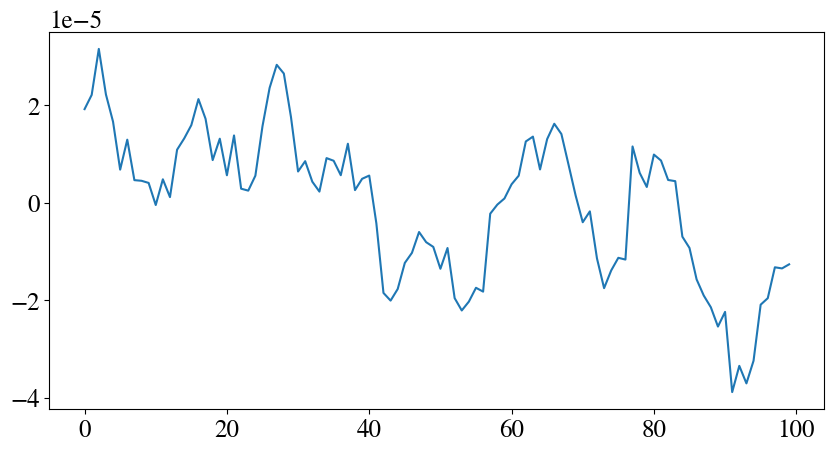

In [99]:
data = dat.get_data();
duration = 100
start = 2000
plt.plot(data[5, start:start+duration])

# Parse seizure onset time info

Test `seiz_lab_fn` and `seiz_lab_from_row_fn` 

In [10]:
all_data = pd.read_csv(root/f"all_data_train.csv", index_col=0);

In [11]:
all_data.head()

,dataset,sub,session,montage,file_stem,relative_path,is_seizure,total_dur,all_chs
0,train,aaaaaaac,s001_2002_12_23,02_tcp_le,aaaaaaac_s001_t000,train/aaaaaaac/s001_2002_12_23/02_tcp_le/aaaaa...,True,301.0,FP1;FP2;F3;F4;C3;C4;A1;A2;P3;P4;O1;O2;F7;F8;T3...
1,train,aaaaaaac,s001_2002_12_23,02_tcp_le,aaaaaaac_s001_t001,train/aaaaaaac/s001_2002_12_23/02_tcp_le/aaaaa...,True,236.0,FP1;FP2;F3;F4;C3;C4;A1;A2;P3;P4;O1;O2;F7;F8;T3...
2,train,aaaaaaac,s002_2002_12_23,02_tcp_le,aaaaaaac_s002_t000,train/aaaaaaac/s002_2002_12_23/02_tcp_le/aaaaa...,True,262.0,FP1;FP2;F3;F4;C3;C4;A1;A2;P3;P4;O1;O2;F7;F8;T3...
3,train,aaaaaaac,s004_2002_12_26,02_tcp_le,aaaaaaac_s004_t000,train/aaaaaaac/s004_2002_12_26/02_tcp_le/aaaaa...,False,321.0,FP1;FP2;F3;F4;C3;C4;A1;A2;P3;P4;O1;O2;F7;F8;T3...
4,train,aaaaaaac,s004_2002_12_26,02_tcp_le,aaaaaaac_s004_t002,train/aaaaaaac/s004_2002_12_26/02_tcp_le/aaaaa...,False,626.0,FP1;FP2;F3;F4;C3;C4;A1;A2;P3;P4;O1;O2;F7;F8;T3...


In [13]:
seiz_lab_from_row_fn(all_data[all_data["is_seizure"]].iloc[5])
#seiz_lab_from_row_fn(all_data.iloc[4])

[(86.0306, 109.6364), (1140.0394, 1185.0722)]

# Data discretization

In [6]:
from data_utils.eeg_load import EEG_data, MyDataLoader
train_data = EEG_data("train_train_health", "AR", 
                      move_dict=dict(winsize=256,
                                     stepsize=256,
                                     marginsize=None),
                      preprocess_dict=dict(is_detrend=True, 
                                      is_drop=True,
                                      target_fs=90, 
                                      filter_limit=[1, 45], 
                                      is_diff=False)
                     )

## minmax check

In [8]:
from data_utils.eeg_load import robust_EEG_rescale

In [9]:
data = train_data["sub1"];
data_minmax = robust_EEG_rescale(data);

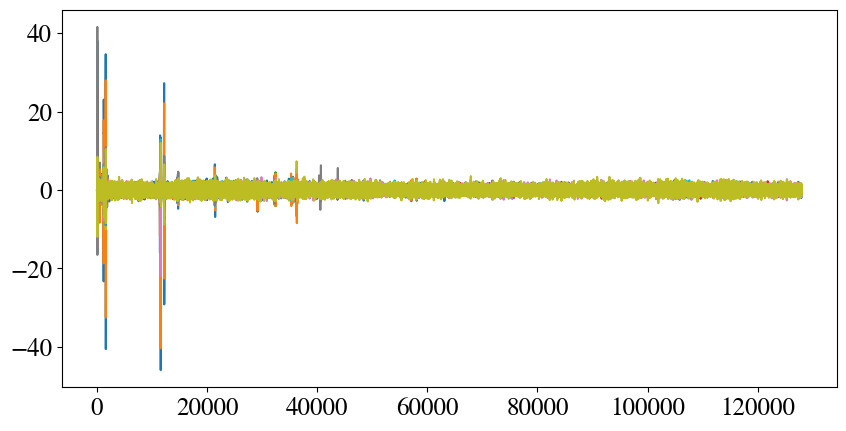

In [12]:
seq_idx = 10
for seq_idx in range(19):
    plt.plot(data_minmax[:, seq_idx])
#plt.ylim([-2, 2])

## Data checking

In [13]:
num_sample_data = 20
all_data = train_data.all_data;
num_cls = 2**8
num_cls_h = (num_cls/2)
qs = np.arange(1, num_cls_h)/num_cls_h;

heal_idxs = np.random.choice(np.arange(len(all_data))[all_data["is_seizure"]==False], size=int(num_sample_data/1));
heal_idxs_test = np.random.choice(np.arange(len(all_data))[all_data["is_seizure"]==False], size=int(num_sample_data/1));

In [14]:
qv = 0.95
vec_heal = np.concatenate([robust_EEG_rescale(train_data[f"sub{idx}"].flatten(), np.quantile(np.abs(train_data[f"sub{idx}"]), [qv])) 
                           for idx in heal_idxs]);
vec_heal_test = np.concatenate([robust_EEG_rescale(train_data[f"sub{idx}"].flatten(), np.quantile(np.abs(train_data[f"sub{idx}"]), [qv])) 
                                for idx in heal_idxs_test]);
vec_heal_abs = np.abs(vec_heal);
vec_heal_test_abs = np.abs(vec_heal_test);
cut_heal = np.quantile(vec_heal_abs, qs)
cut_heal_test = np.quantile(vec_heal_test_abs, qs)

diff1 = np.abs(cut_heal - cut_heal_test)/(cut_heal+cut_heal_test)/2;
cut_heal1 = cut_heal;

In [15]:
qv = 0.998
vec_heal = np.concatenate([
    robust_EEG_rescale(train_data[f"sub{idx}"].flatten(), np.quantile(np.abs(train_data[f"sub{idx}"]), [qv])) 
    #robust_EEG_rescale(train_data[f"sub{idx}"].flatten(), np.abs(train_data[f"sub{idx}"]).max())
                           for idx in heal_idxs]);
vec_heal_test = np.concatenate([
    robust_EEG_rescale(train_data[f"sub{idx}"].flatten(), np.quantile(np.abs(train_data[f"sub{idx}"]), [qv])) 
    #robust_EEG_rescale(train_data[f"sub{idx}"].flatten(), np.abs(train_data[f"sub{idx}"]).max())
                                for idx in heal_idxs_test]);
vec_heal_abs = np.abs(vec_heal);
vec_heal_test_abs = np.abs(vec_heal_test);
cut_heal = np.quantile(vec_heal_abs, qs)
cut_heal_test = np.quantile(vec_heal_test_abs, qs)

diff2 = np.abs(cut_heal - cut_heal_test)/(cut_heal+cut_heal_test)/2;
cut_heal2 = cut_heal;

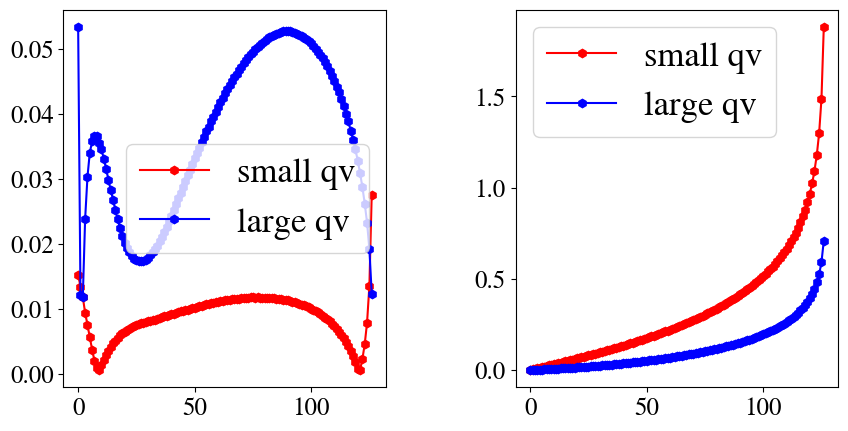

In [16]:
plt.subplot(121)
plt.plot(diff1, "h-r", label="small qv")
plt.plot(diff2, "h-b", label="large qv")
plt.legend()

plt.subplot(122)
plt.plot(cut_heal1, "h-r", label="small qv")
plt.plot(cut_heal2, "h-b", label="large qv")
plt.legend()

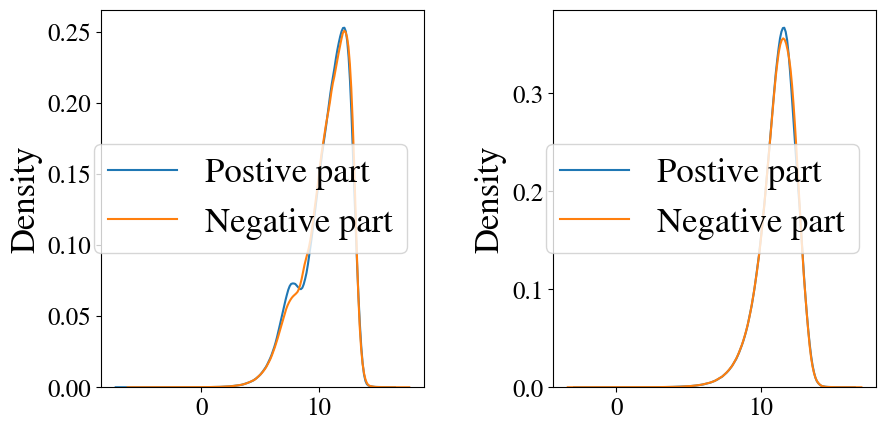

In [171]:
# the data are overall sym around 0 (not need to run)
sns.kdeplot(np.log(vec_heal[vec_heal>=0]), label="Postive part")
sns.kdeplot(np.log(np.abs(vec_heal[vec_heal<0])), label="Negative part")
plt.legend()

## Generate cutoffs and save

In [7]:
train_data = EEG_data("train_train_health", "AR", 
                      move_dict=dict(winsize=256,
                                     stepsize=256,
                                     marginsize=None),
                      preprocess_dict=dict(is_detrend=True, 
                                      is_drop=True,
                                      target_fs=90, 
                                      filter_limit=[1, 45], 
                                      is_diff=False),
                     scale_fct=None)

In [37]:
# only get the cuts on the healthy data
num_sample_data = 40
all_data = train_data.all_data;

heal_idxs = np.random.choice(np.arange(len(all_data))[all_data["is_seizure"]==False], size=int(num_sample_data/1));

vec_uni = np.concatenate([
    train_data[f"sub{idx}"].flatten()
    #robust_EEG_rescale(train_data[f"sub{idx}"].flatten())
                          for idx 
                          in heal_idxs]);
vec_uni_abs = np.abs(vec_uni);

(0.0, 2.0)

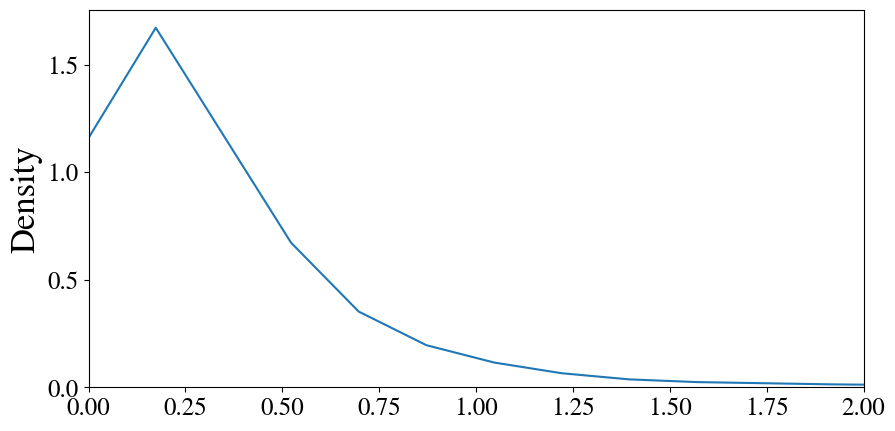

In [38]:
sel_idxs = np.random.choice(vec_uni_abs.shape[0], size=10000);
sns.kdeplot(vec_uni_abs[sel_idxs])
plt.xlim([0, 2])

In [39]:
# save the cuts
k = 5 #num_cls = 2**k
for k in range(5, 13):
    num_cls_h = 2**(k-1)
    qs = np.arange(1, num_cls_h)/num_cls_h;
    cuts = np.quantile(vec_uni_abs, qs)
    
    save_pkl(root/f"discrete_cuts/cuts_2power{k}_rescale_health.pkl", cuts, is_force=True)
    print(cuts[-2:])

Save to /data/rajlab1/user_data/jin/MyResearch/gTVDN-NN/notebooks/../mypkg/../data/EEG_seizure/discrete_cuts/cuts_2power5_rescale_health.pkl
[0.65820003 0.90912305]
Save to /data/rajlab1/user_data/jin/MyResearch/gTVDN-NN/notebooks/../mypkg/../data/EEG_seizure/discrete_cuts/cuts_2power6_rescale_health.pkl
[0.90912305 1.21399755]
Save to /data/rajlab1/user_data/jin/MyResearch/gTVDN-NN/notebooks/../mypkg/../data/EEG_seizure/discrete_cuts/cuts_2power7_rescale_health.pkl
[1.21399755 1.6021488 ]
Save to /data/rajlab1/user_data/jin/MyResearch/gTVDN-NN/notebooks/../mypkg/../data/EEG_seizure/discrete_cuts/cuts_2power8_rescale_health.pkl
[1.6021488  2.12966241]
Save to /data/rajlab1/user_data/jin/MyResearch/gTVDN-NN/notebooks/../mypkg/../data/EEG_seizure/discrete_cuts/cuts_2power9_rescale_health.pkl
[2.12966241 2.9578686 ]
Save to /data/rajlab1/user_data/jin/MyResearch/gTVDN-NN/notebooks/../mypkg/../data/EEG_seizure/discrete_cuts/cuts_2power10_rescale_health.pkl
[2.9578686  4.36589588]
Save to /

## Discretize the data

In [51]:
k = 8
data = train_data["sub8"];
data_discrete = digitize_data(data, k, True);
data_rec = rec_data(data_discrete, k, True);
#cutoffs = load_pkl(root/f"discrete_cuts/cuts_2power{k}_rescale_health.pkl");
#cutoffs_full = np.sort(np.concatenate([-cutoffs, [0], cutoffs]));

Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN-NN/notebooks/../mypkg/../data/EEG_seizure/discrete_cuts/cuts_2power8_rescale_health.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN-NN/notebooks/../mypkg/../data/EEG_seizure/discrete_cuts/cuts_2power8_rescale_health.pkl


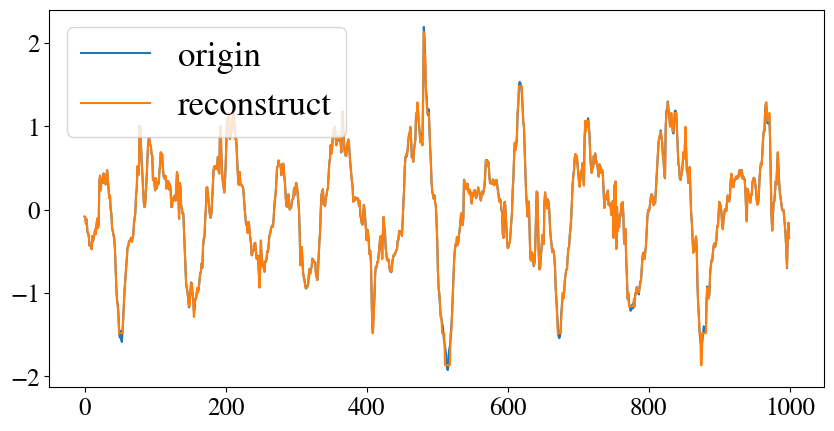

In [52]:
seq_idx = 1
seq_org = data[:1000, seq_idx]
seq_dis = data_discrete[:1000, seq_idx];
seq_rec = data_rec[:1000, seq_idx];

plt.plot(seq_org, label="origin")
plt.plot(seq_rec, label="reconstruct")
plt.legend()

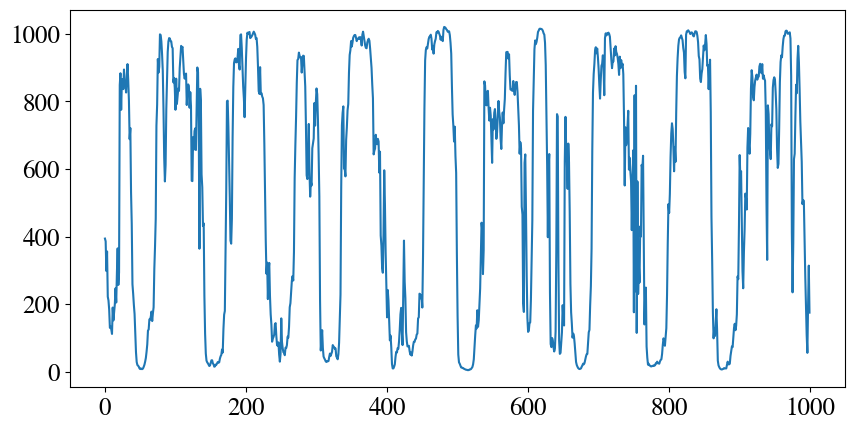

In [49]:
plt.plot(seq_dis)